In [3]:
import torch
from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()

    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [5]:
# specify the image classes
classes = ['airplane', 'automobile']

# Filter the dataset to include only the samples corresponding to the desired classes
def FilterDataset (dataset,class_labels):
  filtered_dataset = []
  for i in range(len(dataset)):
    image, label = dataset[i]
    class_name = dataset.classes[label]
    if class_name in class_labels:
      filtered_dataset.append((image, class_labels.index(class_name)))
  inputs, labels = zip(*filtered_dataset)
  # Convert the filtered dataset to a PyTorch dataset
  filtered_trainset = torch.utils.data.TensorDataset(torch.stack(inputs), torch.tensor(labels))

  return filtered_dataset

# number of subprocesses to use for data loading
num_workers = 2
# how many samples per batch to load
train_batch_size = 128
test_batch_size = 128

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize inputs
])

# filter datasets
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
filtered_trainset = FilterDataset(trainset,classes)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
filtered_testset = FilterDataset(testset,classes)

# Split the filtered dataset into training and validation sets
train_size = int(0.8 * len(filtered_trainset))
valid_size = len(filtered_trainset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(filtered_trainset, [train_size, valid_size])

# Load dataets
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=num_workers)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=train_batch_size, shuffle=False, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(filtered_testset, batch_size=test_batch_size, shuffle=False, num_workers=num_workers)
# images, labels = next(iter(trainloader))
# print(type(images))
# print(images.shape)
# print(labels.shape)
# # choose the training and test datasets
# train_data = datasets.CIFAR10('data', train=True,
#                               download=True, transform=transform)
# test_data = datasets.CIFAR10('data', train=False,
#                              download=True, transform=transform)

# # obtain training indices that will be used for validation
# num_train = len(train_data)
# indices = list(range(num_train))
# np.random.shuffle(indices)
# split = int(np.floor(valid_size * num_train))
# train_idx, valid_idx = indices[split:], indices[:split]

# # define samplers for obtaining training and validation batches
# train_sampler = SubsetRandomSampler(train_idx)
# valid_sampler = SubsetRandomSampler(valid_idx)

# # prepare data loaders (combine dataset and sampler)
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=train_batch_size,
#     sampler=train_sampler, num_workers=num_workers)
# valid_loader = torch.utils.data.DataLoader(train_data, batch_size=train_batch_size,
#     sampler=valid_sampler, num_workers=num_workers)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=test_batch_size,
#     num_workers=num_workers)


100%|██████████| 170498071/170498071 [00:03<00:00, 45319888.62it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# clone googlenet model with pretrained weights
model = models.googlenet(pretrained=True)
model = model.to(device)
# change fc layer in model due to our desire num of classes
num_classes = 2
model.fc = nn.Linear(model.fc.in_features, num_classes)
#let's see the model
# from torchsummary import summary
# summary(model, input_size=(3, 32, 32))
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)

In [ ]:
# Training loop with loss and accuracy tracking
num_epochs = 10
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []
best_valid_accuracy = 0.0  # Track the best validation accuracy

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # Ensure model parameters are on the same device as inputs
        model = model.to(inputs.device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for i, data in enumerate(validloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = valid_loss / len(validloader)
    epoch_accuracy = correct / total

    valid_losses.append(epoch_loss)
    valid_accuracies.append(epoch_accuracy)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Valid Loss: {valid_losses[-1]:.4f}, Valid Accuracy: {valid_accuracies[-1]:.4f}")

    # Save the model if the current validation accuracy is the best so far
    if epoch_accuracy >= best_valid_accuracy:
        best_valid_accuracy = epoch_accuracy
        torch.save(model.state_dict(), 'best_model.pt')

Epoch [1/10], Train Loss: 0.3585, Train Accuracy: 0.8320, Valid Loss: 0.1828, Valid Accuracy: 0.9360
Epoch [2/10], Train Loss: 0.1089, Train Accuracy: 0.9584, Valid Loss: 0.1188, Valid Accuracy: 0.9580
Epoch [3/10], Train Loss: 0.0397, Train Accuracy: 0.9861, Valid Loss: 0.1244, Valid Accuracy: 0.9540
Epoch [4/10], Train Loss: 0.0161, Train Accuracy: 0.9945, Valid Loss: 0.1482, Valid Accuracy: 0.9555
Epoch [5/10], Train Loss: 0.0169, Train Accuracy: 0.9946, Valid Loss: 0.1447, Valid Accuracy: 0.9585
Epoch [6/10], Train Loss: 0.0083, Train Accuracy: 0.9976, Valid Loss: 0.1436, Valid Accuracy: 0.9620
Epoch [7/10], Train Loss: 0.0043, Train Accuracy: 0.9990, Valid Loss: 0.1553, Valid Accuracy: 0.9620
Epoch [8/10], Train Loss: 0.0034, Train Accuracy: 0.9991, Valid Loss: 0.1430, Valid Accuracy: 0.9615
Epoch [9/10], Train Loss: 0.0021, Train Accuracy: 0.9995, Valid Loss: 0.1441, Valid Accuracy: 0.9630
Epoch [10/10], Train Loss: 0.0031, Train Accuracy: 0.9992, Valid Loss: 0.1478, Valid Accura

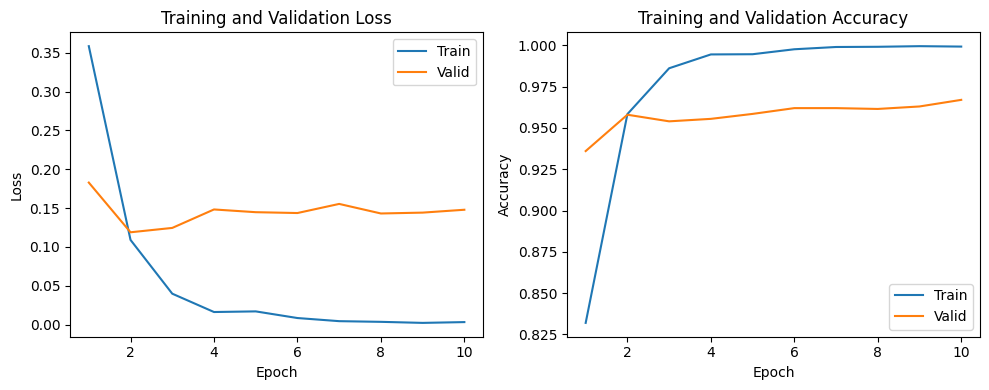

In [ ]:
# Plotting the loss and accuracy for training and validation sets
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train')
plt.plot(epochs, valid_losses, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train')
plt.plot(epochs, valid_accuracies, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Load the best model
best_model = models.googlenet(pretrained=True)
best_model.fc = nn.Linear(best_model.fc.in_features, num_classes)
best_model.load_state_dict(torch.load('best_model.pt'))
best_model = best_model.to(device)
best_model.eval()


test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = best_model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate average test loss and accuracy
avg_test_loss = test_loss / len(testloader)
test_accuracy = correct / total

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.1934, Test Accuracy: 0.9555


In [7]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = F.pairwise_distance(anchor, positive)
        distance_negative = F.pairwise_distance(anchor, negative)
        loss = F.relu(distance_positive - distance_negative + self.margin)
        return loss.mean()
    def create_triplet(self, inputs, labels):
      anchors, positives, negatives = [], [], []
      for i in range(len(inputs)):
        anchor = inputs[i]
        label = labels[i]
        positive_mask = labels == label
        negative_mask = labels != label
        positive_items = inputs[positive_mask]
        negative_items = inputs[negative_mask]
        positive = random.choice(positive_items)
        negative = random.choice(negative_items)
        anchors.append(anchor)
        positives.append(positive)
        negatives.append(negative)
      # convert the list of triplets to tensors
      return torch.stack(anchors), torch.stack(positives), torch.stack(negatives)



In [15]:
# clone googlenet model with pretrained weights
model = models.googlenet(pretrained=True)
# model.fc = nn.Linear(model.fc.in_features, num_classes)
model_fc_excluded = nn.Sequential(*list(model.children())[:-1])  # Exclude the last fully connected layer
model_fc_excluded = model_fc_excluded.to(device)

# Define separate optimizers for the fully connected layer and the rest of the model
optimizer_fc_excluded = optim.SGD(model_fc_excluded.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)

criterion_triplet = TripletLoss(margin = 1.0)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
# Training loop with loss and accuracy tracking
num_epochs = 10

for epoch in range(num_epochs):
    model_fc_excluded.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # Ensure model parameters are on the same device as inputs
        # model = model.to(inputs.device)
        optimizer_fc_excluded.zero_grad()

        anchors, positives, negatives = criterion_triplet.create_triplet(inputs, labels)
        outputs_anchor = model_fc_excluded(anchors).squeeze()
        # outputs = model_fc_excluded(anchors)
        outputs_positives = model_fc_excluded(positives).squeeze()
        outputs_negatives = model_fc_excluded(negatives).squeeze()

        # print(outputs_anchor.shape)
        # print(outputs_positives.shape)
        # print(outputs_negatives.shape)
        loss_triplet = criterion_triplet.forward(outputs_anchor, outputs_positives, outputs_negatives)
        loss_triplet.backward()
        # Update parameters for the fully connected layer
        optimizer_fc_excluded.step()
        running_loss += loss_triplet.item()
    print(f"Epoch [{epoch + 1}/{num_epochs}], Triplet Loss: {running_loss / len(trainloader):.4f}")


Epoch [1/10], Triplet Loss: 1.1080
Epoch [2/10], Triplet Loss: 0.5979
Epoch [3/10], Triplet Loss: 0.3434
Epoch [4/10], Triplet Loss: 0.2245
Epoch [5/10], Triplet Loss: 0.2080
Epoch [6/10], Triplet Loss: 0.1231
Epoch [7/10], Triplet Loss: 0.0971
Epoch [8/10], Triplet Loss: 0.0645
Epoch [9/10], Triplet Loss: 0.0559
Epoch [10/10], Triplet Loss: 0.0352


In [17]:
num_epochs = 10
# change fc layer in model due to our desire num of classes
num_classes = 2
model_full = nn.Sequential(
    model_fc_excluded,
    nn.Flatten(),
    nn.Linear(model.fc.in_features, num_classes))
model_full = model_full.to(device)
optimizer_full_model = optim.SGD(model_full.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
criterion_ce = nn.CrossEntropyLoss()

# Now, train and evaluate the model
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []
best_valid_acc = 0.0 # Track the best validation accuracy


for param in model_full[:-1].parameters():
    param.requires_grad = False

# Assuming you have already defined the model_full, optimizer_full_model, criterion_ce, trainloader, and validloader
# Training loop with validation
for epoch in range(num_epochs):
    model_full.train()
    running_loss_ce = 0.0
    correct_train = 0
    total_train = 0

    # Training phase
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_full_model.zero_grad()

        # Forward pass for the fully connected layer
        outputs_fc_full_model = model_full(inputs)

        # Compute cross-entropy loss
        loss_ce = criterion_ce(outputs_fc_full_model, labels)

        loss_ce.backward()
        optimizer_full_model.step()

        running_loss_ce += loss_ce.item()

        # Compute training accuracy
        _, predicted_train = torch.max(outputs_fc_full_model, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()



    # Validation phase
    model_full.eval()
    total_correct_valid = 0
    total_samples_valid = 0
    total_loss_ce_valid = 0.0

    with torch.no_grad():
        for data_valid in validloader:
            inputs_valid, labels_valid = data_valid
            inputs_valid, labels_valid = inputs_valid.to(device), labels_valid.to(device)

            # Forward pass for the fully connected layer
            outputs_fc_full_model_valid = model_full(inputs_valid)

            # Compute cross-entropy loss
            loss_ce_valid = criterion_ce(outputs_fc_full_model_valid, labels_valid)

            total_loss_ce_valid += loss_ce_valid.item()

            # Compute validation accuracy
            _, predicted_valid = torch.max(outputs_fc_full_model_valid, 1)
            total_samples_valid += labels_valid.size(0)
            total_correct_valid += (predicted_valid == labels_valid).sum().item()

    # Calculate average loss and accuracy for both training and validation
    average_loss_ce_train = running_loss_ce / len(trainloader)
    accuracy_train = correct_train / total_train

    average_loss_ce_valid = total_loss_ce_valid / len(validloader)
    accuracy_valid = total_correct_valid / total_samples_valid


    train_losses.append(average_loss_ce_train)
    train_accuracies.append(accuracy_train)
    valid_losses.append(average_loss_ce_valid)
    valid_accuracies.append(accuracy_valid)

    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Train Loss: {average_loss_ce_train:.4f}, Train Accuracy: {accuracy_train:.4f}, "
          f"Valid Loss: {average_loss_ce_valid:.4f}, Valid Accuracy: {accuracy_valid:.4f}")
    if accuracy_valid >= best_valid_acc:
      best_valid_acc = accuracy_valid
      # torch.save(model_full.state_dict(), 'best_model_triplet.pt')
      torch.save(model_full, 'best_model_triplet.pt')


Epoch [1/10], Train Loss: 0.0789, Train Accuracy: 0.9794, Valid Loss: 0.2001, Valid Accuracy: 0.9540
Epoch [2/10], Train Loss: 0.0321, Train Accuracy: 0.9960, Valid Loss: 0.1994, Valid Accuracy: 0.9540
Epoch [3/10], Train Loss: 0.0290, Train Accuracy: 0.9960, Valid Loss: 0.1973, Valid Accuracy: 0.9525
Epoch [4/10], Train Loss: 0.0266, Train Accuracy: 0.9959, Valid Loss: 0.1984, Valid Accuracy: 0.9535
Epoch [5/10], Train Loss: 0.0265, Train Accuracy: 0.9961, Valid Loss: 0.2000, Valid Accuracy: 0.9540
Epoch [6/10], Train Loss: 0.0249, Train Accuracy: 0.9956, Valid Loss: 0.2040, Valid Accuracy: 0.9520
Epoch [7/10], Train Loss: 0.0265, Train Accuracy: 0.9948, Valid Loss: 0.2062, Valid Accuracy: 0.9560
Epoch [8/10], Train Loss: 0.0233, Train Accuracy: 0.9951, Valid Loss: 0.2005, Valid Accuracy: 0.9530
Epoch [9/10], Train Loss: 0.0193, Train Accuracy: 0.9964, Valid Loss: 0.1955, Valid Accuracy: 0.9555
Epoch [10/10], Train Loss: 0.0194, Train Accuracy: 0.9960, Valid Loss: 0.1929, Valid Accura

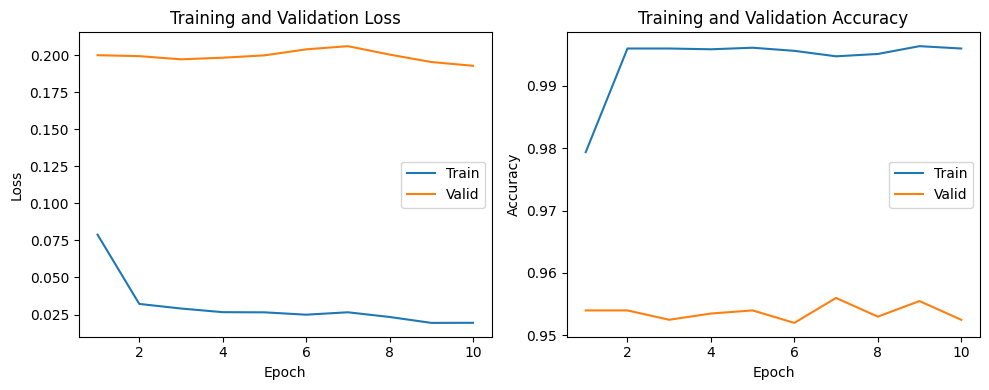

In [18]:
# Plotting the loss and accuracy for training and validation sets
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train')
plt.plot(epochs, valid_losses, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train')
plt.plot(epochs, valid_accuracies, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
# Load the best model
# best_model_triplet = models.googlenet(pretrained=True)
# best_model_triplet.fc = nn.Linear(best_model_triplet.fc.in_features, num_classes)
# best_model_triplet.load_state_dict(torch.load('best_model_triplet.pt'))
best_model_triplet = torch.load('best_model_triplet.pt')
best_model_triplet = best_model_triplet.to(device)

best_model_triplet.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = best_model_triplet(inputs)
        loss = criterion_ce(outputs, labels)

        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate average test loss and accuracy
avg_test_loss = test_loss / len(testloader)
test_accuracy = correct / total

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.1841, Test Accuracy: 0.9625


In [29]:
# clone googlenet model with pretrained weights
model_total = models.googlenet(pretrained=True)
num_classes = 2
model_total.fc = nn.Linear(model_total.fc.in_features, num_classes)
model_total = model_total.to(device)
# Define separate optimizers for the fully connected layer and the rest of the model
optimizer_total = optim.SGD(model_total.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)

criterion_triplet = TripletLoss(margin = 1.0)
criterion_ce = nn.CrossEntropyLoss()

In [30]:
num_epochs = 10

# Now, train and evaluate the model
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []
best_valid_acc = 0.0 # Track the best validation accuracy


# Assuming you have already defined the model_full, optimizer_full_model, criterion_ce, trainloader, and validloader
# Training loop with validation
for epoch in range(num_epochs):
  model_total.train()
  running_loss = 0.0
  correct_train = 0
  total_train = 0

  # Training phase
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer_total.zero_grad()

    # Compute cross-entropy loss
    outputs = model_total(inputs)
    loss_ce = criterion_ce(outputs, labels)
    # Compute triplet loss
    anchors, positives, negatives = criterion_triplet.create_triplet(inputs, labels)
    # outputs_anchor = model_total(anchors).squeeze()
    outputs_positives = model_total(positives)
    outputs_negatives = model_total(negatives)
    loss_triplet = criterion_triplet.forward(outputs, outputs_positives, outputs_negatives)

    total_loss = loss_triplet + loss_ce

    total_loss.backward()
    optimizer_total.step()

    running_loss += total_loss.item()

    # Compute training accuracy
    _, predicted_train = torch.max(outputs, 1)
    total_train += labels.size(0)
    correct_train += (predicted_train == labels).sum().item()

  # Validation phase
  model_total.eval()
  correct_valid = 0
  total_valid = 0
  running_valid_loss = 0.0

  with torch.no_grad():
    for data_valid in validloader:
      inputs_valid, labels_valid = data_valid
      inputs_valid, labels_valid = inputs_valid.to(device), labels_valid.to(device)

      # Compute cross-entropy loss for validation
      outputs_valid = model_total(inputs_valid)
      loss_ce_valid = criterion_ce(outputs_valid, labels_valid)
      # Compute cross-entropy loss for validation
      anchors, positives, negatives = criterion_triplet.create_triplet(inputs_valid, labels_valid)
      outputs_positives = model_total(positives)
      outputs_negatives = model_total(negatives)
      loss_triplet_valid = criterion_triplet.forward(outputs_valid, outputs_positives, outputs_negatives)
      # Compute validation accuracy
      _, predicted_valid = torch.max(outputs_valid, 1)
      total_valid += labels_valid.size(0)
      correct_valid += (predicted_valid == labels_valid).sum().item()

      total_loss_valid = loss_ce_valid + loss_triplet_valid
      running_valid_loss += total_loss_valid.item()

  # Calculate average loss and accuracy for validation



  # Calculate average loss and accuracy for both training and validation
  average_loss_train = running_loss / len(trainloader)
  accuracy_train = correct_train / total_train

  average_loss_valid = running_valid_loss / len(validloader)
  accuracy_valid = correct_valid / total_valid

  # Append values to lists for plotting
  train_losses.append(average_loss_train)
  train_accuracies.append(accuracy_train)
  valid_losses.append(average_loss_valid)
  valid_accuracies.append(accuracy_valid)

  # Print and plot results
  print(f"Epoch [{epoch + 1}/{num_epochs}], "
      f"Train Loss: {running_loss / len(trainloader):.4f}, Train Accuracy: {correct_train / total_train:.4f}, "
      f"Valid Loss: {average_loss_valid:.4f}, Valid Accuracy: {accuracy_valid:.4f}")

  # Save the model if validation accuracy improves
  if accuracy_valid > best_valid_acc:
    best_valid_acc = accuracy_valid
    torch.save(model_total, 'best_model_total.pt')

Epoch [1/10], Train Loss: 0.8870, Train Accuracy: 0.8556, Valid Loss: 0.7825, Valid Accuracy: 0.8805
Epoch [2/10], Train Loss: 0.3765, Train Accuracy: 0.9491, Valid Loss: 0.4128, Valid Accuracy: 0.9420
Epoch [3/10], Train Loss: 0.1836, Train Accuracy: 0.9760, Valid Loss: 0.3859, Valid Accuracy: 0.9505
Epoch [4/10], Train Loss: 0.1010, Train Accuracy: 0.9851, Valid Loss: 0.4342, Valid Accuracy: 0.9455
Epoch [5/10], Train Loss: 0.0826, Train Accuracy: 0.9886, Valid Loss: 0.4413, Valid Accuracy: 0.9440
Epoch [6/10], Train Loss: 0.0583, Train Accuracy: 0.9921, Valid Loss: 0.3923, Valid Accuracy: 0.9495
Epoch [7/10], Train Loss: 0.0472, Train Accuracy: 0.9940, Valid Loss: 0.4681, Valid Accuracy: 0.9530
Epoch [8/10], Train Loss: 0.0332, Train Accuracy: 0.9961, Valid Loss: 0.5019, Valid Accuracy: 0.9510
Epoch [9/10], Train Loss: 0.0489, Train Accuracy: 0.9934, Valid Loss: 0.4501, Valid Accuracy: 0.9530
Epoch [10/10], Train Loss: 0.0244, Train Accuracy: 0.9971, Valid Loss: 0.4824, Valid Accura

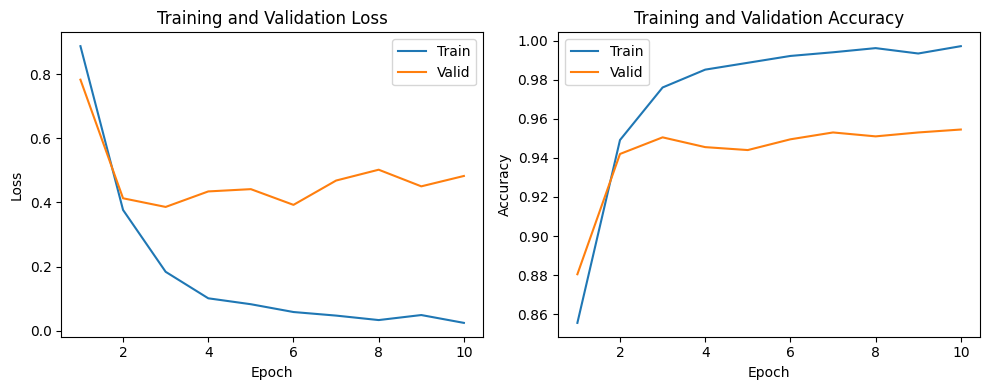

In [31]:
# Plotting the loss and accuracy for training and validation sets
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train')
plt.plot(epochs, valid_losses, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train')
plt.plot(epochs, valid_accuracies, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [32]:
# Load the best model
# best_model_triplet = models.googlenet(pretrained=True)
# best_model_triplet.fc = nn.Linear(best_model_triplet.fc.in_features, num_classes)
# best_model_triplet.load_state_dict(torch.load('best_model_triplet.pt'))
best_model_triplet = torch.load('best_model_total.pt')
best_model_triplet = best_model_triplet.to(device)

best_model_triplet.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = best_model_triplet(inputs)
        loss = criterion_ce(outputs, labels)

        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate average test loss and accuracy
avg_test_loss = test_loss / len(testloader)
test_accuracy = correct / total

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.1307, Test Accuracy: 0.9650
